In [ ]:
%%capture
%load_ext autoreload
%autoreload 2
%reset -f

In [ ]:
import os

import jax
import numpy as np
import optax
from jax import numpy as jnp
from matplotlib import pyplot as plt

import otf.utils.error_surfaces as es
from otf import optim
from otf import time_integration as ti
from otf.asyncd import utils
from otf.system import base as system_base

jax.config.update("jax_platform_name", "cpu")
jax.config.update("jax_enable_x64", True)

jndarray = jnp.ndarray
ndarray = np.ndarray

FIGURES_FOLDER = os.path.join(os.getcwd(), "figures", "full-observations")
os.makedirs(FIGURES_FOLDER, exist_ok=True)

In [ ]:
def get_initial_values():
    # Initial true state
    u0 = jnp.array([0, -1], dtype=complex)

    # Initial simulation state
    un0 = jnp.zeros_like(u0)

    return u0, un0


def true_ode(gs: jndarray, true: jndarray) -> jndarray:
    m, b = gs

    x, y = true

    return jnp.array([y, m * (1 - x**b) * y - x])


def assimilated_ode(cs: jndarray, nudged: jndarray) -> jndarray:
    m, b = cs

    x, y = nudged

    return jnp.array([y, m * (1 - x**b) * y - x])


true0, assimilated0 = get_initial_values()

# System evolution parameters
gs = m, b = 0.01, 2.15
gs = jnp.array(gs, dtype=complex)
cs_center = gs.copy()

mu = 10
observed_slice = jnp.s_[:]
system = system_base.System_ModelKnown(
    mu,
    gs,
    None,
    observed_slice,
    assimilated_ode,
    true_ode,
    complex_differentiation=True,
)

# Simulation parameters
dt = 0.01
T0, Tf = 0, 200
sim_Tf = 600
sim_t_relax = 1

solver = ti.ForwardEuler(system)
solver = ti.TwoStepAdamsBashforth(system, solver)

optimizer_options = {"optimizer": optax.adam(1e-2)}
optimizer_type = optim.OptaxWrapper

true, _ = solver.solve_true(true0, T0, sim_Tf, dt)
true_observed = true[:, observed_slice]

In [ ]:
n = 21
xn = n
yn = n
x_relative_bound = (-4, 6)
y_relative_bound = (-0.5, 4)

# Use coordinate directions scaled by the size of the true parameters.
dirs = np.array([[gs[0], 0], [0, gs[1]]])

surface_results = list()

surface_result = es.get_surface(
    system,
    true_observed,
    solver,
    dt,
    T0,
    Tf,
    assimilated0,
    cs_center,
    dirs,
    true_actual=true,
    xn=xn,
    yn=yn,
    x_relative_bound=x_relative_bound,
    y_relative_bound=y_relative_bound,
)
surface_results.append(surface_result)

In [ ]:
first_relative_position = (2, 1.5)
start_cs = es.get_cs_from_relative_position(
    cs_center, dirs, first_relative_position
)

trajectory_results = list()

start_relative_position = es.get_relative_position_from_cs(
    cs_center, dirs, start_cs
)
system.cs = es.get_cs_from_relative_position(
    cs_center, dirs, start_relative_position
)
optimizer = optimizer_type(system, **optimizer_options)
trajectory_result = es.get_trajectory(
    system,
    true_observed,
    solver,
    dt,
    T0,
    sim_Tf,
    sim_t_relax,
    assimilated0,
    optimizer,
    cs_center,
    dirs,
    run_update_options={
        "parameter_update_option": utils.ParameterUpdateOption.mean_gradient
    },
)
trajectory_results.append(trajectory_result)

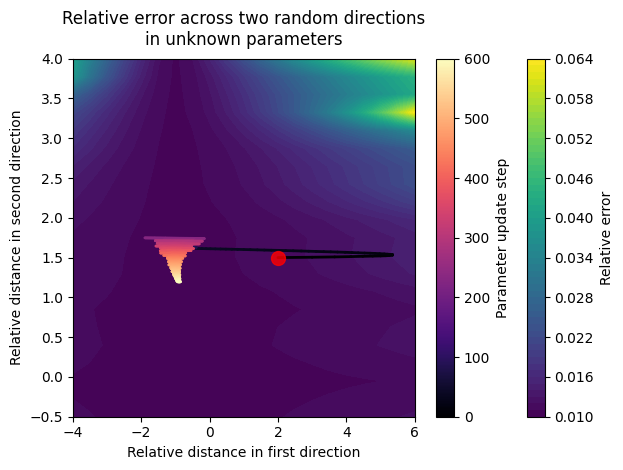

In [ ]:
for i, (surface_result, trajectory_result) in enumerate(
    zip(surface_results, trajectory_results)
):
    fig, ax = plt.subplots(1, 1)

    errors, xls, yls = surface_result
    es.plot_surface(fig, ax, errors, xls, yls, levels=60)

    _, cs_coordinates = trajectory_result
    es.plot_trajectory(fig, ax, cs_coordinates.real)

    ax.set_xlabel("Relative distance in first direction")
    ax.set_ylabel("Relative distance in second direction")
    ax.set_title(
        "Relative error across two random directions\nin unknown parameters",
        pad=10,
    )
    fig.tight_layout()
    fig.savefig(
        os.path.join(FIGURES_FOLDER, f"error-surface_{i:0>3}.svg"),
        format="svg",
    )